In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import brentq

In [3]:
plt.rcParams["figure.figsize"] = (14,4)

#### Quantizer function 

In [5]:
class quantizer:
    # implements a uniform deadzone quantizer with M levels over the [-A, A] interval
    def __init__(self, M, A=1):
        assert M % 2 == 1, "only considering mid-thread quantizers"
        self.clip = A
        self.offset = (M - 1) // 2
        self.step = 2 * A / M 
        
    def qbin(self, x):
        # return the INDEX of the quantization bin, i.e. an integer in the range [0, M-1]
        if np.max(np.abs(x)) > self.clip:
            raise OverflowError
        return (np.floor(x / self.step + 0.5) + self.offset).astype(int)
    
    def qvalue(self, i):
        # quantization value for bin i
        return self.step * (i - self.offset)
    
    def quantize(self, x):
        # return the quantized value
        return self.qvalue(self.qbin(x))
    
    def qthreshold(self, ix, iy):
        # return the midpoint between quantization bins ix and iy
        assert abs(ix - iy) == 1, "trying to obtain the threshold across more than 2 quantization levels"
        ix = ix + (0.5 if iy > ix else -0.5)
        return (ix - self.offset) * self.step
    
    def step(self):
        return self.step

In [59]:
T_test = 1/1.2

def test_func(x):
    f0 = 1.2 # Hz
    return 0.9 * np.cos(2 * np.pi * f0 * x) 
    '''
def test_func(x):
    f0 = 1.2 # Hz
    return 0.9 * np.sin(2 * np.pi * f0 * x) 
'''

-0.2


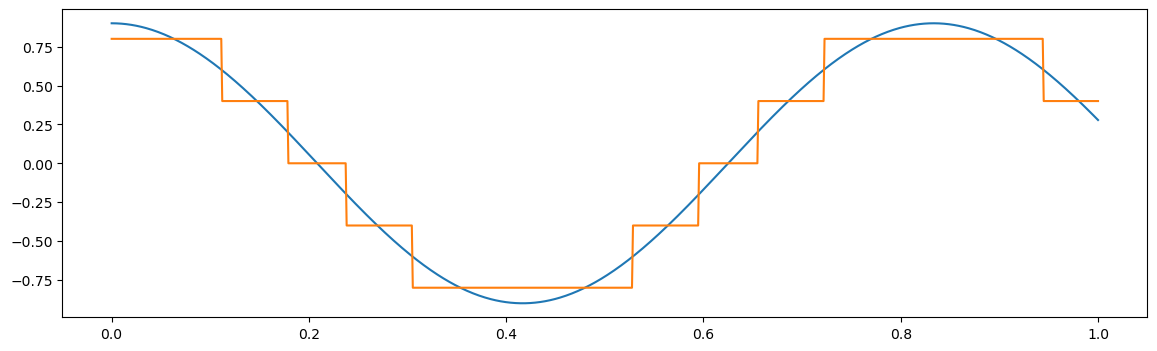

In [60]:
q = quantizer(5)
step = q.step

print(q.qthreshold(1,2))

n_range = np.linspace(0, 1, 1000)
plt.plot(n_range, test_func(n_range))
plt.plot(n_range, q.quantize(test_func(n_range)));

#### Amplitude sampler function

In [61]:
def amplitude_sampler(f, T, Q, gd=1000):
    # f : input function
    # T : function period
    # Q : quantizer
    # gd : points per period in initial sampling grid
    
    def shifted_f(x, offset):
        # wrapper to shift the input function 
        return f(x) - offset
    
    transitions, bins = [0], [Q.qbin(f(0))]   # transition times and associated quantization bin
    num_samples = T * gd                      # start with a regular sampling to estimate transition points
    
    for n in range(1, num_samples):
        t = n * T / num_samples
        i = Q.qbin(f(t))
        if i != bins[-1]:
            # a level transition has occurred. Find the exact time
            #  first determine the value for the amplitude crossing
            threshold = Q.qthreshold(bins[-1], i)
            #  then determine the exact crossing time between neighboring samples
            transitions.append(brentq(shifted_f, (n - 1) * T / num_samples, t, args=threshold))
            bins.append(i)
    return np.array(transitions), np.array(bins)

Transition instants: [0.         0.1115502  0.17861206 0.2380546  0.30511647 0.52821686
 0.59527873 0.65472127 0.72178314 0.94488353]
Bins index: [4 3 2 1 0 1 2 3 4 3]


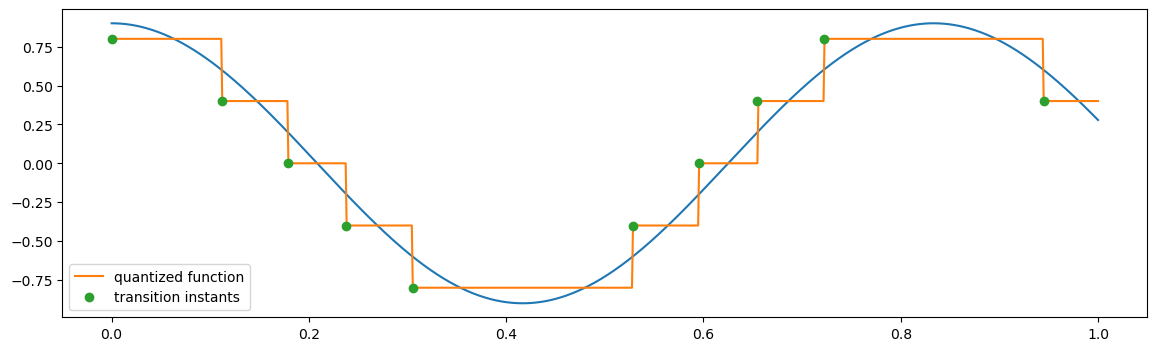

In [62]:
T = 1
n_range = np.linspace(0, T, 1000)

# transitions and bins
t, q_idx = amplitude_sampler(test_func, T, q)

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))

# bins to quantization values
a = q.qvalue(q_idx)  #--> find the step y value for each bin 

plt.plot(n_range, test_func(n_range));
plt.plot(n_range, q.quantize(test_func(n_range)), label='quantized function')
plt.plot(t, a, 'o', label='transition instants')
plt.legend()

The following tests show that the transition points are independent of the density of the initial sampling grid

In [63]:
amplitude_sampler(test_func, T, q, gd=10000)[0]

array([0.        , 0.1115502 , 0.17861206, 0.2380546 , 0.30511647,
       0.52821686, 0.59527873, 0.65472127, 0.72178314, 0.94488353])

In [13]:
amplitude_sampler(test_func, T, q, gd=1000)[0]

array([0.        , 0.1115502 , 0.17861206, 0.2380546 , 0.30511647,
       0.52821686, 0.59527873, 0.65472127, 0.72178314, 0.94488353])

In [64]:

amplitude_sampler(test_func, T, q, gd=100)[0]

array([0.        , 0.1115502 , 0.17861206, 0.2380546 , 0.30511647,
       0.52821686, 0.59527873, 0.65472127, 0.72178314, 0.94488353])

Of course, if the sampling grid is too sparse, then we may jump across multiple quantization levels and so the approach fails


In [65]:
try:
    amplitude_sampler(test_func, T, q, gd=10)[0]
except AssertionError:
    print('crossing more than one level')

crossing more than one level


Now decompose the piecewise-constant signal into the sum of individual pulses. Each pulse is defined by a start and stop time

In [66]:
def decompose(t, i, T):
    assert t[0] == 0, 'first transition should be at t=0'
    M = np.max(i)
    pulses = []
    
    for m in range(1, np.max(i)+1):
        t_start = t[0]
        on = (i[0] >= m)    #--> i[0] is the first bin index (in the previous case it's the highest)
        
        for n in range(1, len(i)):
            if on and i[n] < m:
                on = False
                pulses.append((t_start, t[n]))
            elif not on and i[n] == m:
                on = True
                t_start = t[n]
        if on:
            pulses.append((t_start, T))
    return pulses

In [73]:
decompose(t, q_idx, T)

[(0.0, 0.3051164696661542),
 (0.5282168636671792, 1),
 (0.0, 0.23805460279375962),
 (0.5952787305399516, 1),
 (0.0, 0.17861206387290707),
 (0.6547212694600484, 1),
 (0.0, 0.11155019700051251),
 (0.7217831363328209, 0.9448835303338459)]

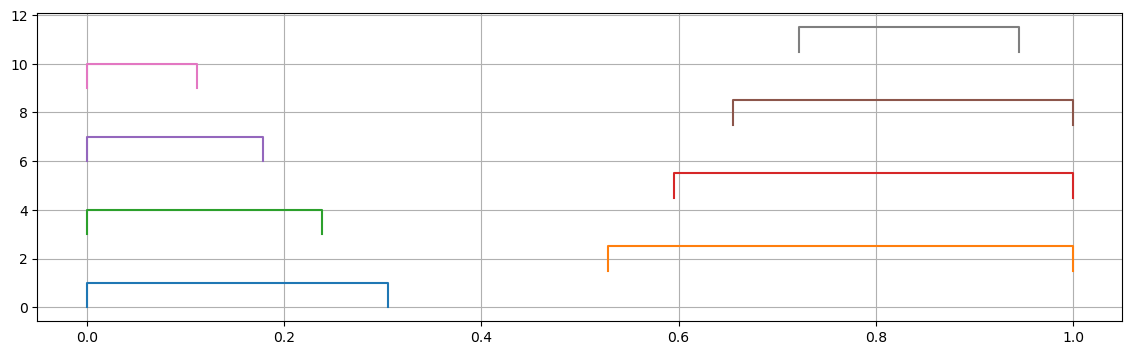

In [68]:
n = 0

for p in decompose(t, q_idx, T):
    plt.plot([p[0], p[0], p[1], p[1]], [n, n+1, n+1, n])
    n += 1.5

plt.grid()
plt.show()

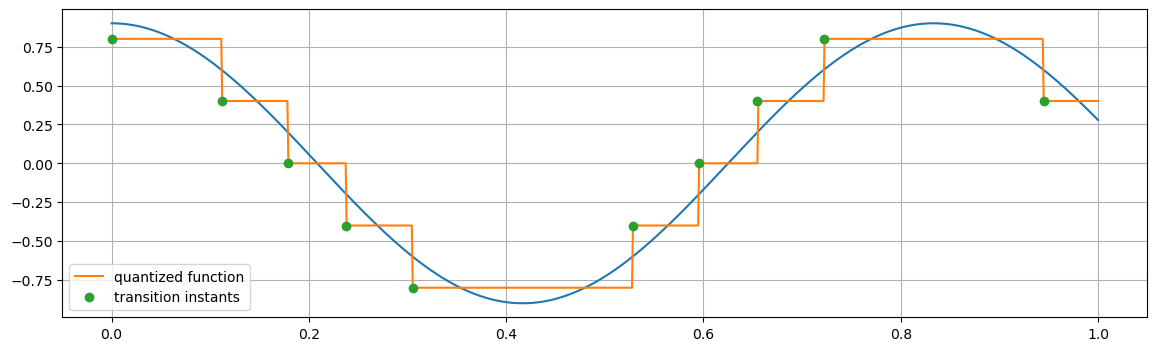

In [69]:
plt.plot(n_range, test_func(n_range));
plt.plot(n_range, q.quantize(test_func(n_range)), label='quantized function')
plt.plot(t, a, 'o', label='transition instants')
plt.grid()
plt.legend()

Let's reconstruct the piecewise amplitude-sampled signal over a discrete grid

In [70]:
def plot_decomposition(pulses, Q, points=1000):
    T = max(list(sum(pulses, ())))
    x = np.zeros(points)
    for p in pulses:
        n = np.round((points / T) * np.array(p)).astype(int)
        x[n[0]:n[1]] += 1
    plt.plot(np.linspace(0, T, points), Q.qvalue(x))

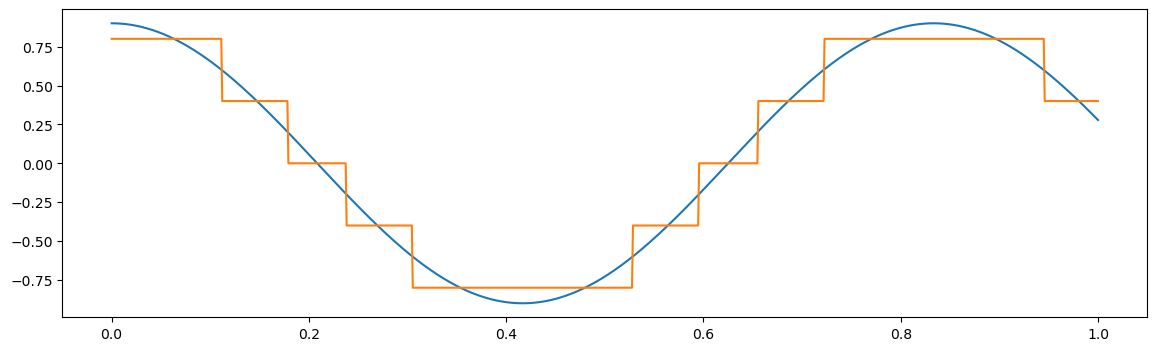

In [71]:
n_range = np.linspace(0, T, 1000)

plt.plot(n_range, test_func(n_range));
plot_decomposition(decompose(t, q_idx, T), q)

### Analytical Fourier series reconstruction 

$ \Large{ c_n = \frac{1}{\pi n} e^{-j 2 \pi n \frac{t}{T} \frac{t_{0} + t_{1}}{2} } sin  \left( 2 \pi n \frac{t}{T} \frac{t_{1} - t_{0}}{2}  \right) }$

$ \large{  f ( x ) =  \sum_n c_{n} e^{j 2 \pi n \frac{1}{T} x }  }$

In [197]:
def FS(n, t0,t1, T, x, delta): 
    F=0
    for i in range(0,n):   #range(int(-n/2), int(n/2))
        c = 1/(np.pi*i) * (np.exp(-1j*2*np.pi*i/T*(t0+t1)/2)*np.sin(2*np.pi*i/T*(t1-t0)/2))
        F_tmp  = delta * c*np.exp(1j*2*np.pi*i*x/T)
        F = F + F_tmp
    return F

In [198]:
# Test 
pulse_times= decompose(t, q_idx, T)

duty_1 = pulse_times[7][0] - pulse_times[6][1]
duty_2 = pulse_times[5][0] - pulse_times[4][1]
duty_3 = pulse_times[3][0] - pulse_times[2][1]
duty_4 = pulse_times[1][0] - pulse_times[0][1]

duty_list = [duty_1, duty_2, duty_3, duty_4]

print ( pulse_times[1][0], pulse_times[0][1], duty_4)


0.5282168636671792 0.3051164696661542 0.22310039400102505
[ 0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8  0.4]


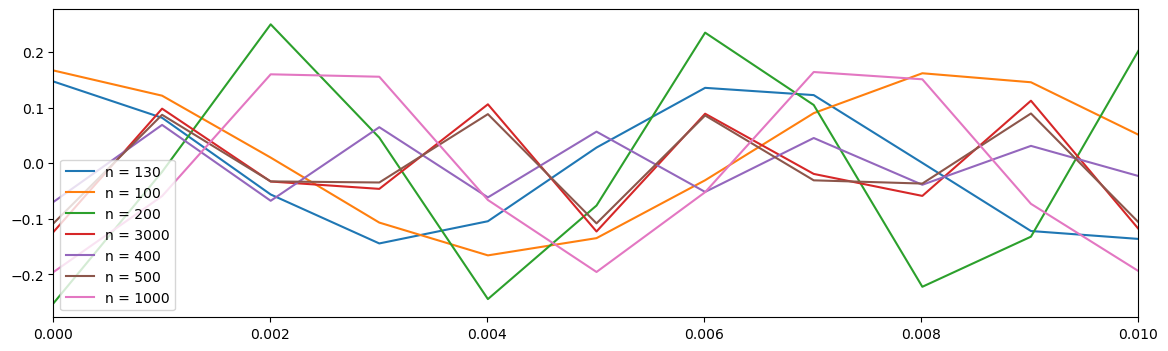

In [99]:
x = np.linspace(0, T, 1000) #time vector 


xf = 

for i in (130,100,200,3000,400,500,1000):
    plt.plot(x,  -FS(i, pulse_times[6][1], pulse_times[7][0], T_test, x, a[0]), label='n = {}'.format(i))
    plt.xlim(0, 0.01)
    plt.legend()

(0.0, 0.021)

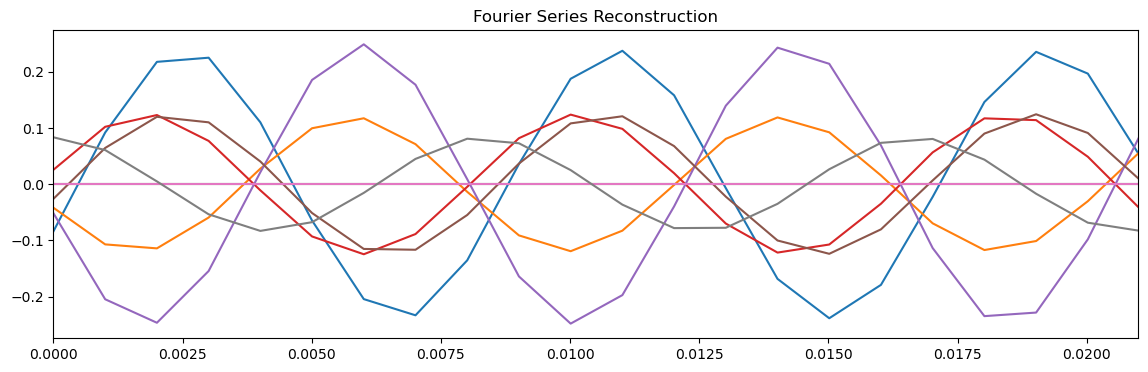

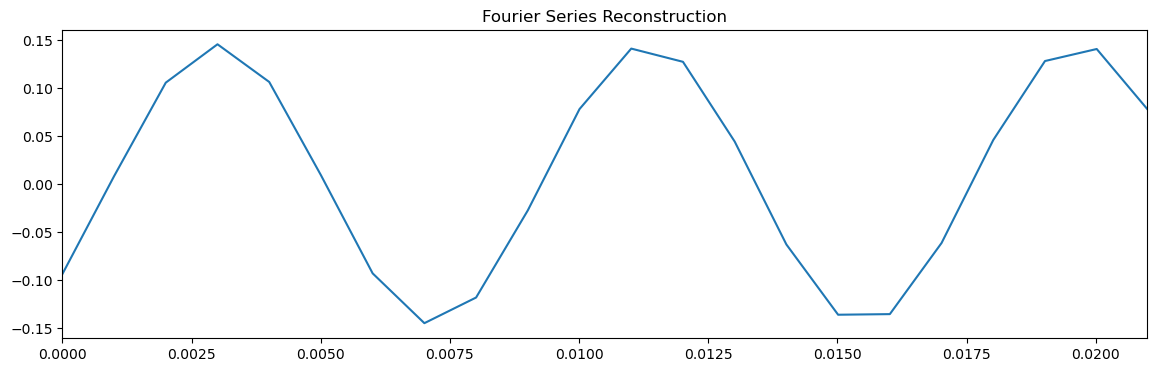

In [47]:

pulse_times= decompose(t, q_idx, T_test)
x = np.linspace(0, T, 1000)

xf = np.zeros((len(pulse_times), len(x)), dtype=complex)

for i in range(len(pulse_times)):
    xf[i, :] = FS(100, pulse_times[i][0], pulse_times[i][1], T_test, x, a[i])

xf_tot = np.sum(xf, axis=0)

plt.figure(figsize=(14,4)) 
for i in range(0,len(xf[:,1])):

    plt.plot(x, xf[i,:], label= 'pulse {}'.format(i))
    
plt.title('Fourier Series Reconstruction')
plt.xlim(0, 0.021)


plt.figure(figsize=(14,4)) 
plt.plot(x, xf_tot, label= 'pulse {}'.format(i))    
plt.title('Fourier Series Reconstruction')
plt.xlim(0, 0.021)

1


In [183]:
# Test 
pulse_times= decompose(t, q_idx, T)

duty_1 = pulse_times[7][0] - pulse_times[6][1]
duty_2 = pulse_times[5][0] - pulse_times[4][1]
duty_3 = pulse_times[3][0] - pulse_times[2][1]

duty_4 = pulse_times[1][0] - pulse_times[0][1]

duty_list = [duty_1, duty_2, duty_3, duty_4]

print ( pulse_times[1][0], pulse_times[0][1], duty_4)

x = np.linspace(0, T, 1000) #time vector
A = 1
T = 1

0.5282168636671792 0.3051164696661542 0.22310039400102505


In [195]:
#Harmonic progresison plot 
def fs_prog(amp, T, n, duty, t ):

    delta = duty/2
    a0 = amp*duty/T
    F = a0 

    for i in range(1,n):  
        an = 2*amp/(i*np.pi) * np.sin(i*2*np.pi*delta/T)
        F_n  = an*np.cos(i*2*np.pi*t/T)

        plt.figure(figsize=(10,2))

    
        plt.plot(x,  F_n, label='an = {}, n={}'.format(an, i))
        plt.legend()
        plt.title('Harmonic')
        plt.show()

        F = F + F_n

        plt.figure(figsize=(10,2))
        plt.plot(x,  F, label='n = {}'.format(i))
        plt.title('Total')
        plt.show()

    return F



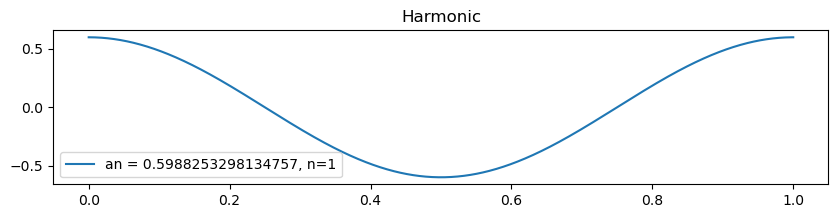

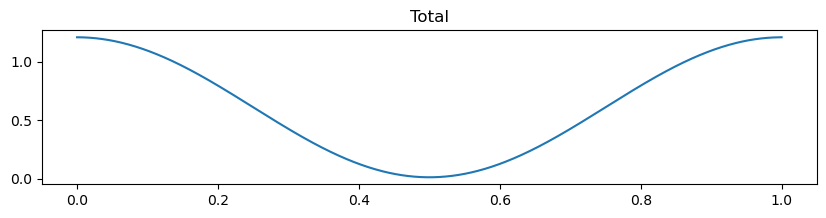

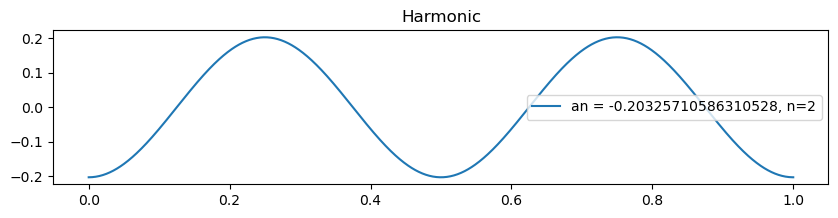

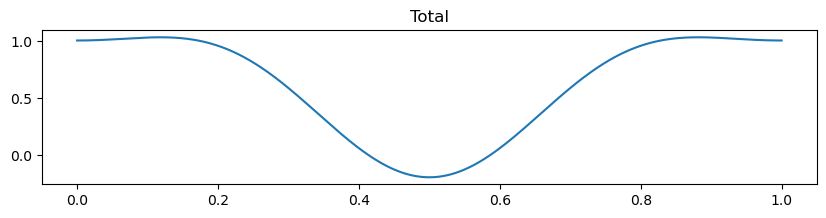

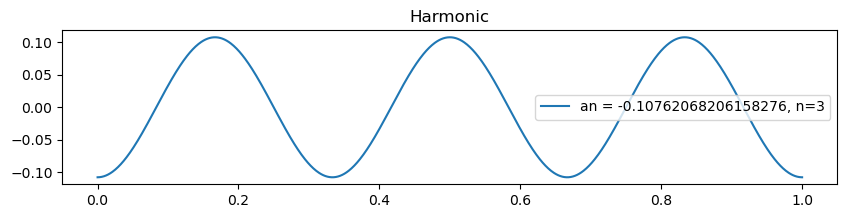

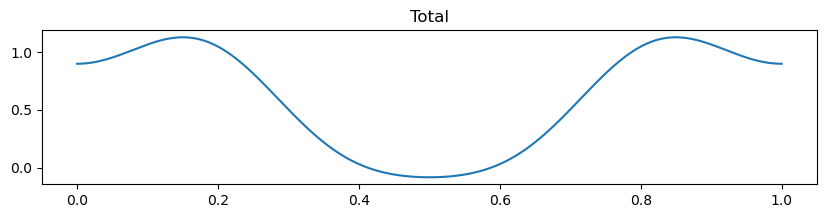

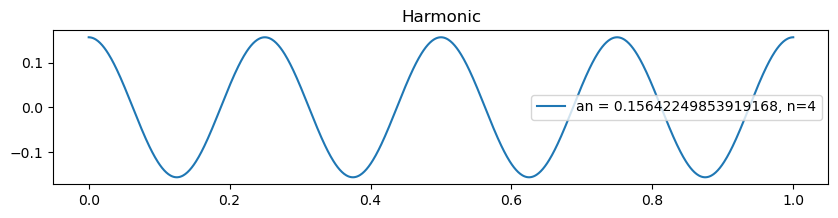

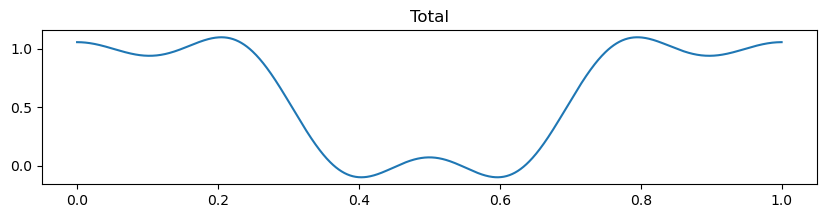

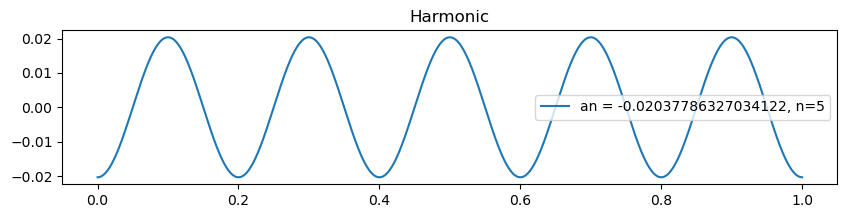

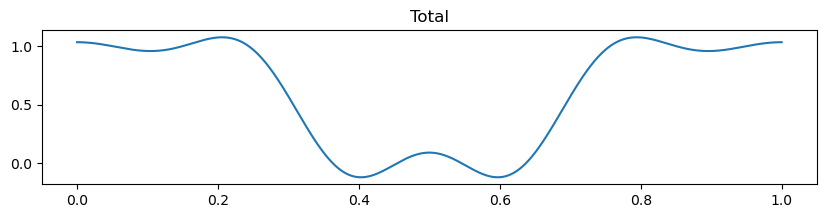

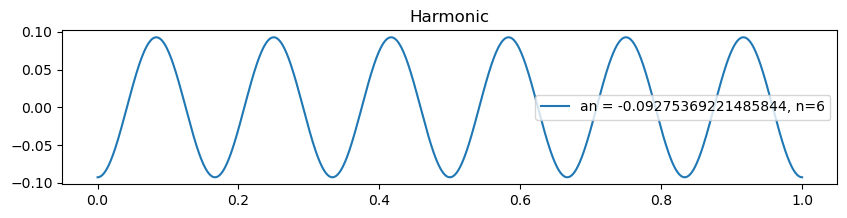

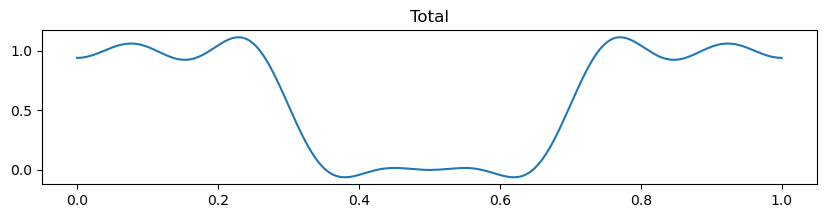

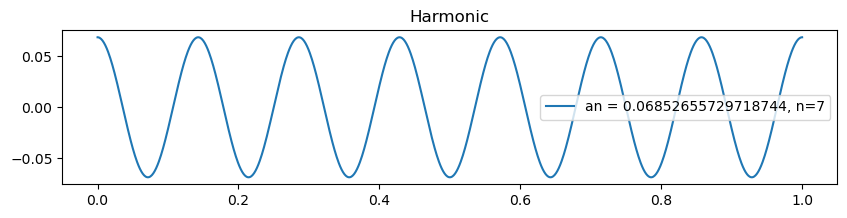

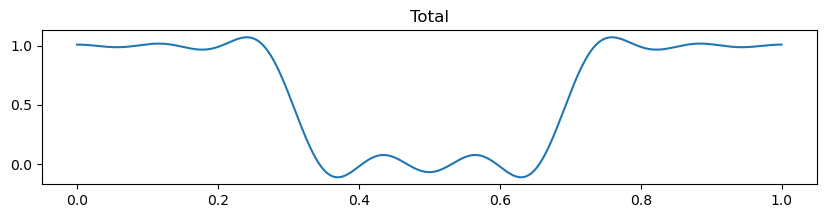

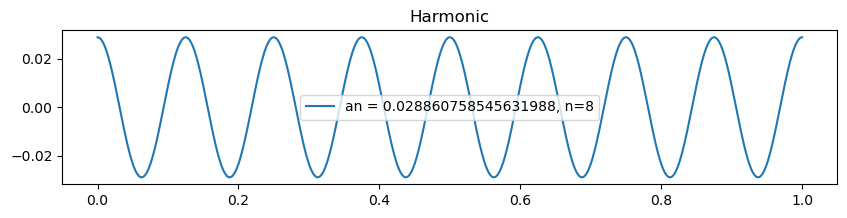

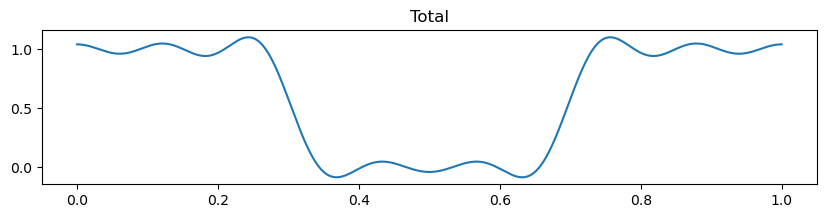

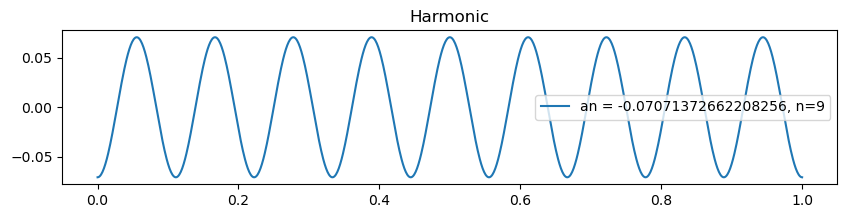

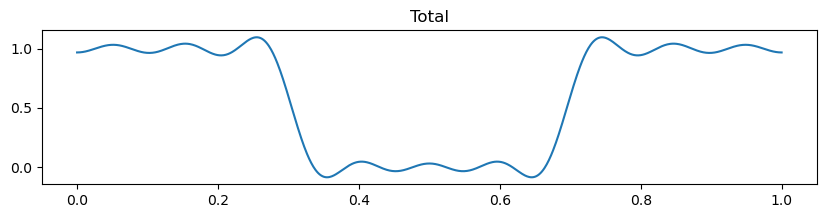

array([ 9.68145013e-01,  9.68205350e-01,  9.68386138e-01,  9.68686707e-01,
        9.69105945e-01,  9.69642302e-01,  9.70293791e-01,  9.71058003e-01,
        9.71932108e-01,  9.72912869e-01,  9.73996653e-01,  9.75179446e-01,
        9.76456864e-01,  9.77824171e-01,  9.79276296e-01,  9.80807852e-01,
        9.82413152e-01,  9.84086236e-01,  9.85820884e-01,  9.87610648e-01,
        9.89448868e-01,  9.91328699e-01,  9.93243137e-01,  9.95185041e-01,
        9.97147163e-01,  9.99122173e-01,  1.00110268e+00,  1.00308128e+00,
        1.00505054e+00,  1.00700307e+00,  1.00893154e+00,  1.01082869e+00,
        1.01268736e+00,  1.01450052e+00,  1.01626131e+00,  1.01796306e+00,
        1.01959929e+00,  1.02116375e+00,  1.02265047e+00,  1.02405374e+00,
        1.02536814e+00,  1.02658859e+00,  1.02771033e+00,  1.02872897e+00,
        1.02964049e+00,  1.03044126e+00,  1.03112804e+00,  1.03169802e+00,
        1.03214882e+00,  1.03247847e+00,  1.03268547e+00,  1.03276877e+00,
        1.03272775e+00,  

In [196]:
#Harmonic progression 
fs_prog(A, T, 10, duty_1, x )

In [193]:
def fs(amp, T, n, duty, t ):

    delta = duty/2
    a0 = amp*duty/T
    F = a0 

    for i in range(1,n):  
        an = 2*amp/(i*np.pi) * np.sin(i*2*np.pi*delta/T)
        F_n  = an*np.cos(i*2*np.pi*t/T)

        F = F + F_n

    return F

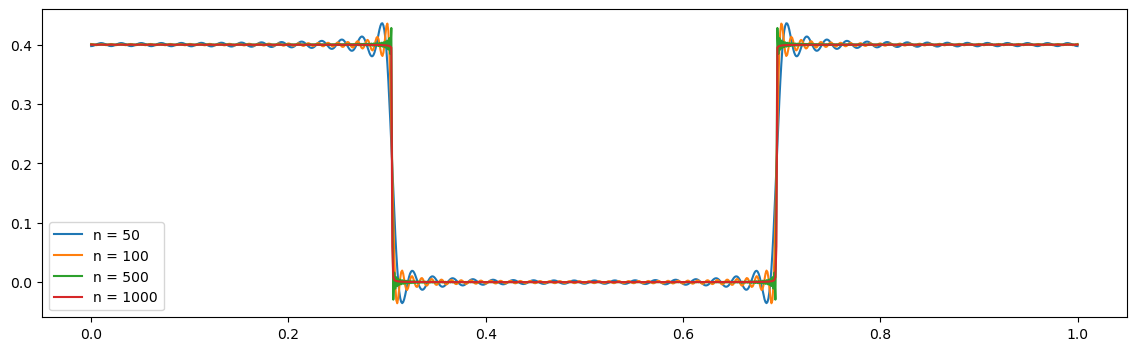

In [194]:
for k in (50,100,500,1000):
    plt.plot(x,  fs(step, T, k, duty_1, x), label='n = {}'.format(k))    
    plt.legend()

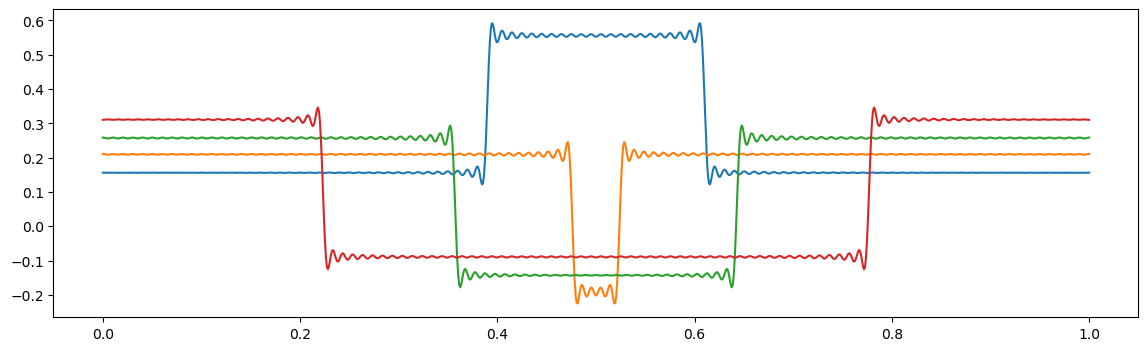

In [191]:
y_tot = np.zeros(len(x))

y_tot = np.zeros(len(x))

for i in duty_list: 
    plt.plot(x, fs(step, T, 100, i, x), label='duty = {}'.format(i))

for i in duty_list: 
    y_tmp = fs(step, T, 100, i, x)
    y_tot = y_tot + y_tmp

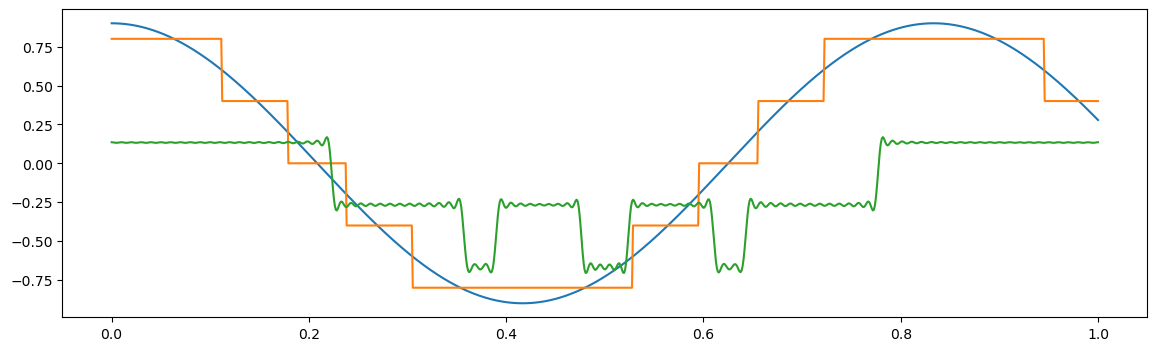

In [192]:
n_range = np.linspace(0, T, 1000)


plt.plot(n_range, test_func(n_range));
plot_decomposition(decompose(t, q_idx, T), q)
plt.plot(x, y_tot-2*step, label='n = {}'.format(k))